In [65]:
import numpy as np
import ProGED as pg
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp
import os
import sys
from ProGED.examples.DS2022.generate_data_ODE_systems import generate_ODE_data, lorenz, VDP
from scipy.integrate import solve_ivp, odeint

In [2]:
problem = "vdp"

np.random.seed(0)

if problem == "lorenz":
    inits = [1,1,1]
    rho = 16
    f = lambda t, x: lorenz(t, x, rho=rho)
elif problem == "vdp":
    inits = [-0.2, -0.8]
    f = VDP

data = generate_ODE_data(f, inits)
T = data[:,0]
deltaT = T[1]-T[0]
X = data[:, 1:]
dX = np.array([np.gradient(Xi, deltaT) for Xi in X.T])

In [3]:
folder = "E:/Dropbox/github/PCFGproject/ProGED/examples/DS2022/results/numdiff/"
file = "numdiff_vdp_poly"
Neq = 2

In [4]:
models = [pg.ModelBox() for i in range(3)]
meantimes = []
for i in range(Neq):
    models[i].load(folder + file + "_eq" + str(i) + "_models_fit.pg")
    times = [m.get_time() for m in models[i]]
    meantimes += [np.mean(times)]
print(meantimes)

[3.5270656019886584, 3.3275900769183298]


In [5]:
for i in range(Neq):
    print("----", i, "----")
    print(models[i].retrieve_best_models(5))

---- 0 ----
ModelBox: 5 models
-> -2.29504350545577e-5*x*y**2 + 2.23436207662132e-5*x + 0.999989681214017*y, p = 4.2998169600000004e-06, parse trees = 3, valid = True, error = 4.58530369043881e-09, time = 6.801198720932007
-> 2.24122023889277e-5*x**3 - 6.50744179852189e-5*x + 0.999978666516431*y, p = 2.8665446400000006e-06, parse trees = 2, valid = True, error = 4.738306510762392e-09, time = 7.3322203159332275
-> 3.66402446233333e-6*x**3 - 2.40871390883756e-6*x**2*y**5 + 0.99999506668639*y, p = 9.172942848000002e-11, parse trees = 1, valid = True, error = 4.817846167165076e-09, time = 9.110679626464844
-> -6.67730707939797e-6*x*y**4 + 7.80956764504427e-6*x*y**2 + 0.999992247302403*y, p = 2.2932357120000007e-09, parse trees = 1, valid = True, error = 4.866860170954648e-09, time = 8.462089776992798
-> -4.40238150095054e-6*x*y**4 + 0.999989967748419*y + 1.17286895431445e-6, p = 8.599633920000001e-07, parse trees = 3, valid = True, error = 4.892291839351163e-09, time = 6.706257104873657
--

In [57]:
thr_error = []
for i in range(Neq):
    thr_error += [np.sqrt(models[i].retrieve_best_models(5)[0].get_error())/dX[i].std()]


In [9]:
succprob = []
curves = []
for i in range(Neq):
   # dat = np.hstack((dX[i].reshape((-1,1)), X))
    SRi, curvesx = pg.postprocessing.resample_curve(models[i], dX, target_variable_index=i, success_threshold=1e-4, resampleN=1000)
    succprob += [SRi/1000]
    curves += [np.mean(curvesx, axis=0)]

(-0.1, 20.0)

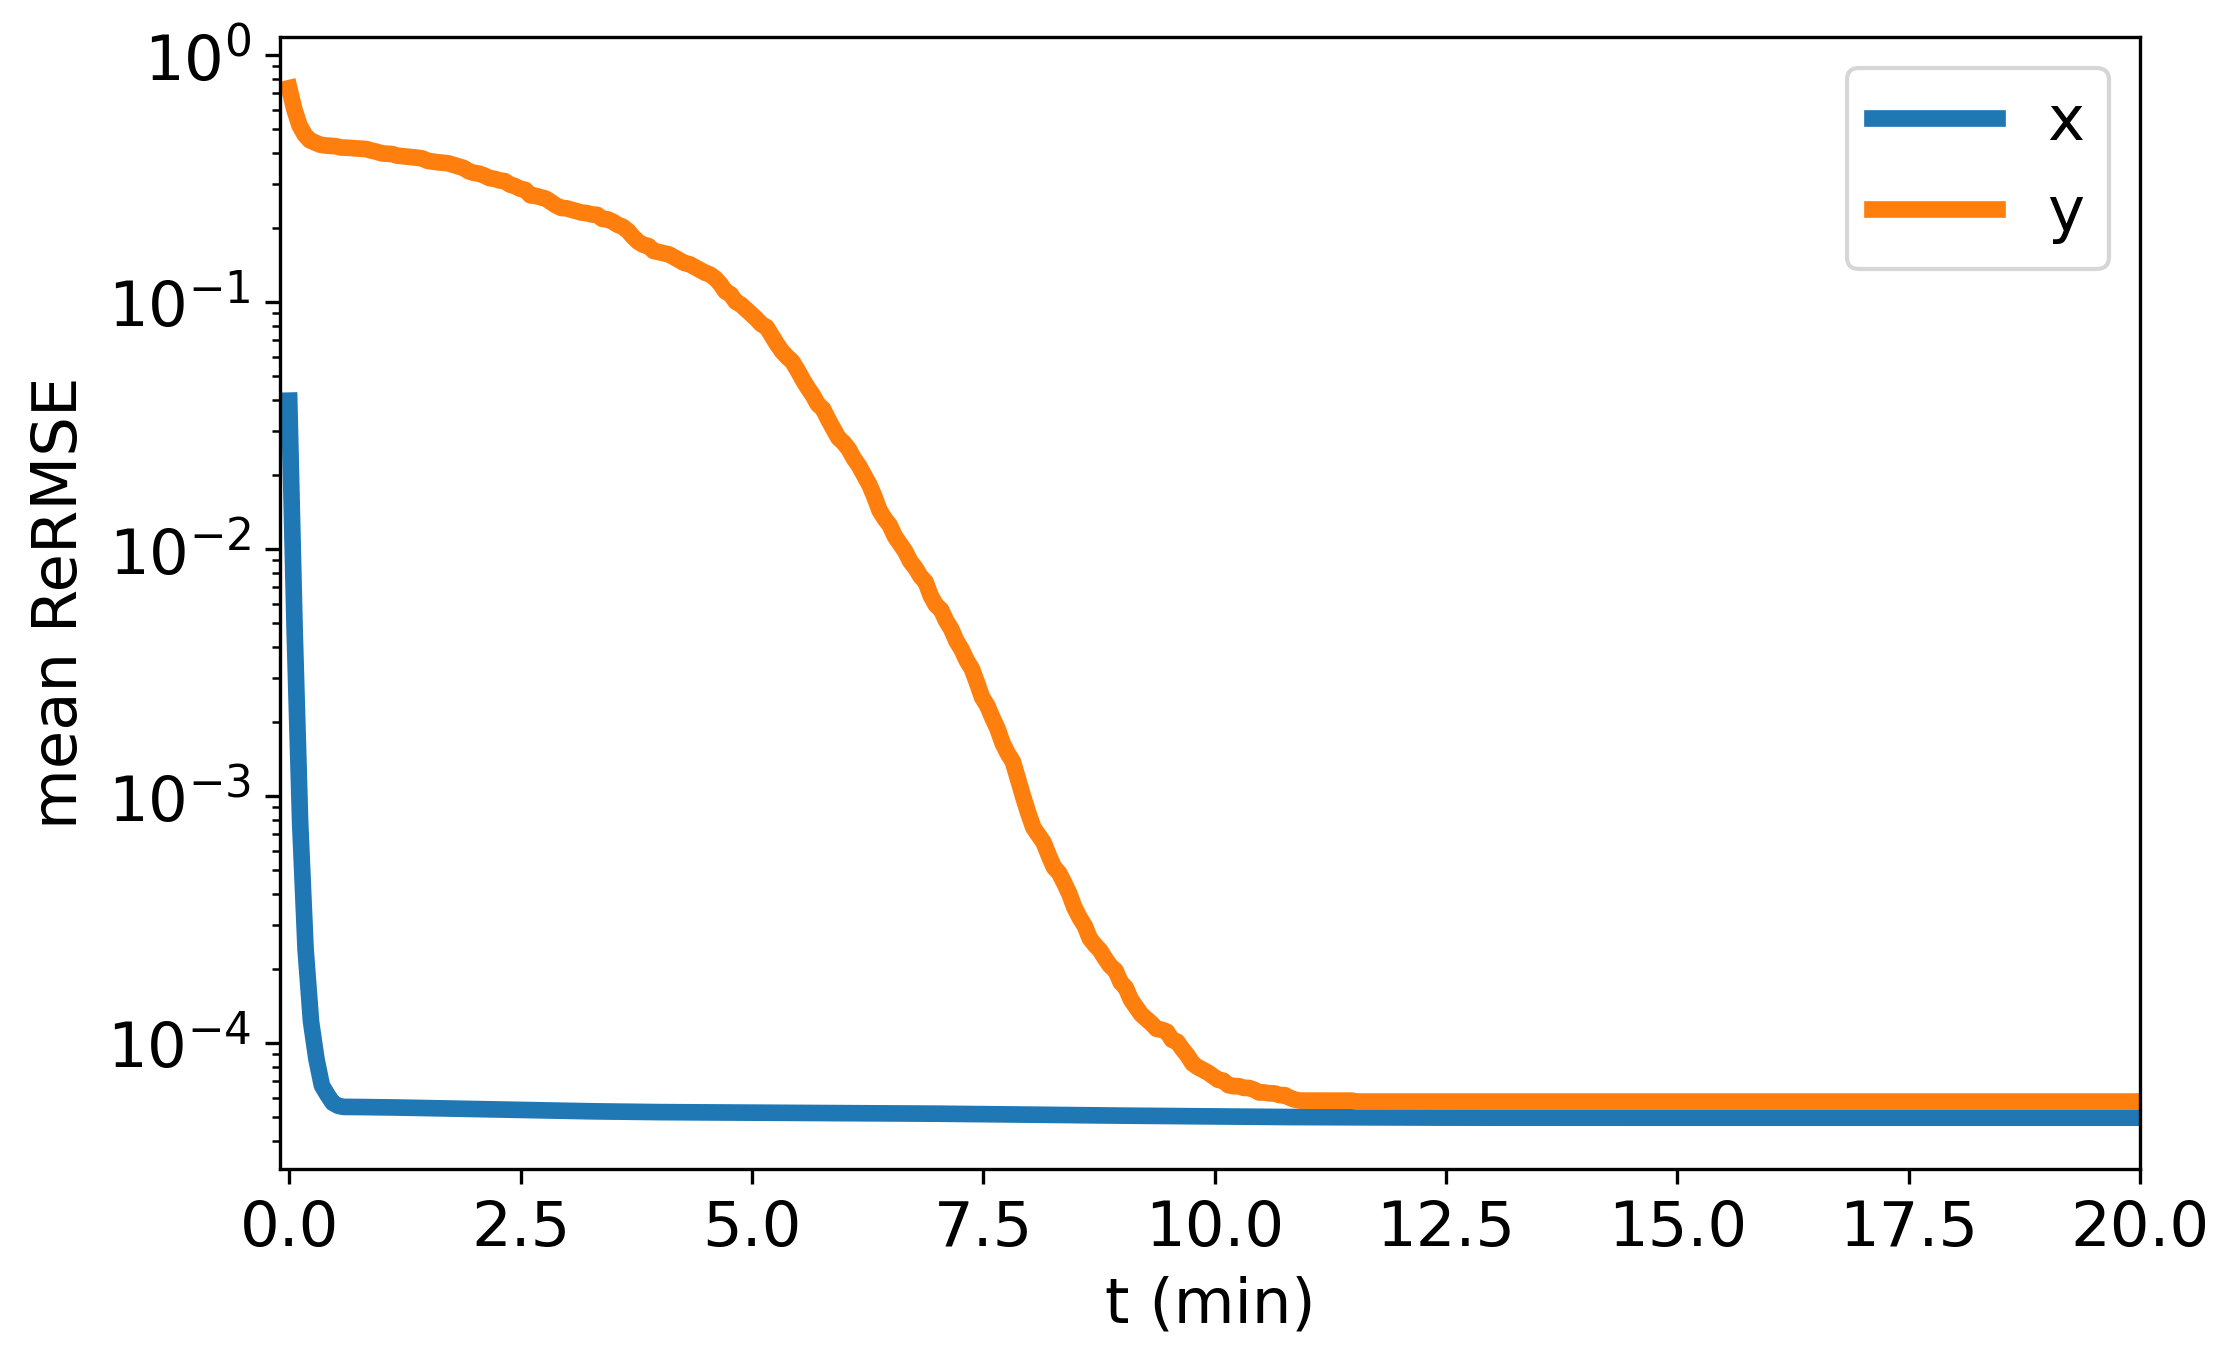

In [59]:
plt.rcParams.update({"font.size": 15})
fig = plt.figure(figsize=(8,5), dpi=300)
colors = ["C0", "C1"]
for i in range(Neq):
    t = np.array(list(range(len(curves[i]))))*meantimes[i]/60
    plt.plot(t, 10**curves[i], label=["x", "y"][i], lw=4, color=colors[i])
    #plt.plot([-5, 25], [thr_error[i], thr_error[i]], color=colors[i])
plt.yscale("log")
plt.legend()
plt.xlabel("t (min)")
plt.ylabel("mean ReRMSE")
plt.xlim(-0.1, 20)

In [64]:
fitted_params = np.array([0.999978656809846, -0.499907276211367, -0.999979301218477, 0.499908874573008])
true_params = np.array([1.0, -0.5, -1.0, 0.5])
print(np.sum(np.sqrt((true_params - fitted_params)**2)))
print((18+586)/60, "min")


0.00022589118730204083
10.066666666666666 min


5
176


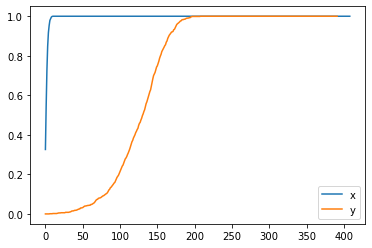

In [12]:
n95 = []
for i in range(Neq):
    plt.plot(succprob[i], label=["x","y","z"][i])
    n95 += [np.where(succprob[i]>0.95)[0][0]]
    print(n95[-1])
plt.legend()

x - 95% success probability:  5 models, 18 seconds
y - 95% success probability:  176 models, 586 seconds


Text(0.5, 1.0, 'ProGED: numeric derivatives, polynomial grammar')

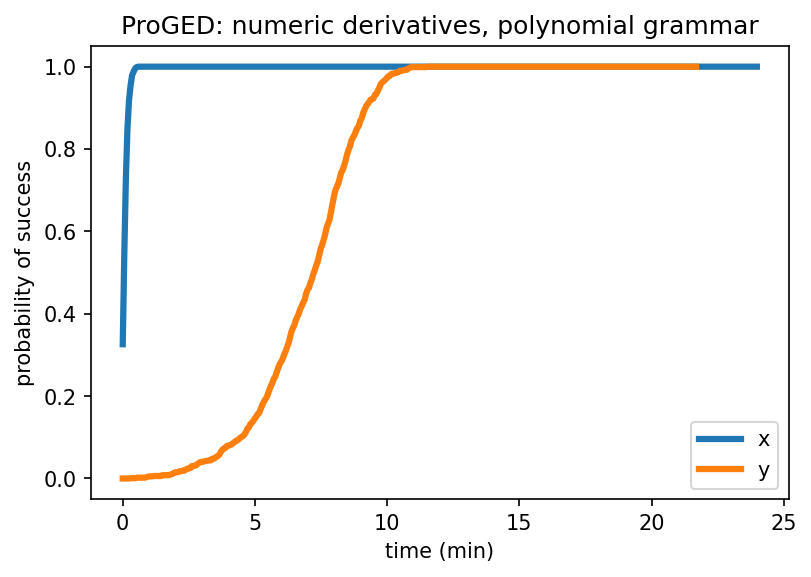

In [15]:
plt.figure(dpi=150)
for i in range(Neq):
    t = np.array(list(range(len(succprob[i]))))*meantimes[i]/60
    plt.plot(t, succprob[i], label=["x","y", "z"][i], lw=3)
    print(["x","y", "z"][i], "- 95% success probability: ", n95[i], "models,", round(meantimes[i]*n95[i]), "seconds")
plt.legend()
plt.xlabel("time (min)")
plt.ylabel("probability of success")
plt.title("ProGED: numeric derivatives, polynomial grammar")

In [17]:
lenmodels = [len(m) for m in models]

[477, 473, 0]

In [29]:
dfs = []
for i in range(Neq):
    df = pd.DataFrame()
    df["N"] = list(range(len(curves[i])))
    df["time"] = np.array(list(range(len(succprob[i]))))*meantimes[i]/60
    df["rrmse"] = curves[i]
    df["success-prob"] = succprob[i] 
    dfs += [df]
    df.to_csv("VDP_numdiff_eq"+str(i)+".csv", index=False)

In [92]:
fitted_params = np.array([0.999978656809846, -0.499907276211367, -0.999979301218477, 0.499908874573008])
def solutionf(t, x):
    return [fitted_params[0]*x[1], fitted_params[1]*x[0]**2*x[1] + fitted_params[2]*x[0] + fitted_params[3]*x[1]]

def solutionf_eql(t, x): 
    return [0.0144/(1.41 - 1.32*np.sin(2.86*t - 1.11*x[1] + 1.21)), 0.047/(1.488-1.45*np.sin(2.92*t-1.077*x[1]))]

inits = [-0.2, -0.8]

Yode, info = odeint(solutionf, inits, T,
                rtol = 1e-12,
                atol = 1e-12,
                tfirst=True,
                full_output=True)

errs = []
for i in range(Neq):
    errs += [np.sqrt(np.mean((Yode[:,i] - X[:,i])**2))/np.std(Yode[:,i])]
print("individual ReRMSE: ", errs)
print("total ReRMSE: ", np.sum(errs))

individual ReRMSE:  [0.0004965657479172534, 0.0005726947933023932]
total ReRMSE:  0.0010692605412196466


[0.0004965657479172534, 0.0005726947933023932]
0.0010692605412196466


In [ ]:
def traj_err(trueX, predX):
    

Text(0, 0.5, 'y')

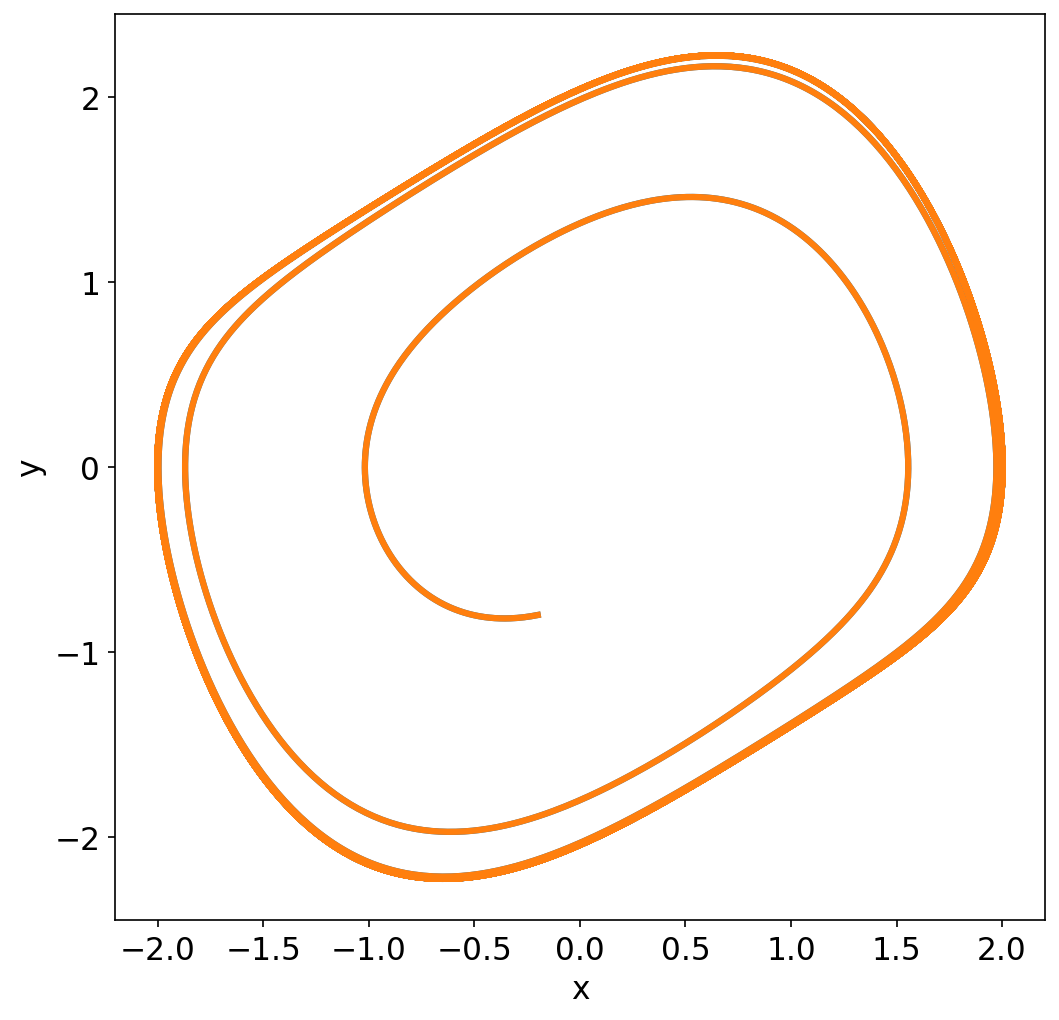

In [91]:
plt.rcParams.update({"font.size":15})
fig = plt.figure(figsize = (8,8), dpi=150)
plt.plot(data[:, 1], data[:, 2], lw=3)
plt.plot(Yode[:,0], Yode[:,1], lw=3)
plt.xlabel("x")
plt.ylabel("y")

In [174]:
from ProGED.generators.grammar_construction import construct_production

if False:
    grammarstr = construct_production("E", ["E '+' F", "E '-' F", "F"], [0.15, 0.15, 0.7])
    grammarstr += construct_production("F", ["F '*' T", "T"], [0.2, 0.8])
    grammarstr += construct_production("T", ["'(' E ')'", "V", "'C'"], [0.2, 0.5, 0.3])
    grammarstr += construct_production("V", ["'x'", "'y'", "'z'"], [1/3, 1/3, 1/3])
if False:
    grammarstr = construct_production("P", ["P '+' M",  "M"], [0.4, 0.6])
    grammarstr += construct_production("M", ["T", "'C' '*' T"], [0.5, 0.5])
    grammarstr += construct_production("T", ["V '*' V", "V"], [1/3, 2/3])
    grammarstr += construct_production("V", ["'x'", "'y'", "'z'"], [1/3, 1/3, 1/3])
if True:
    grammarstr = construct_production("P", ["P '+' M", "M"], [0.4, 0.6])
    grammarstr += construct_production("M", ["V '*' V", "'-' V '*' V", "'C' '*' V"], [0.25, 0.25, 0.5])
    grammarstr += construct_production("V", ["'x'", "'y'", "'z'"], [1/3, 1/3, 1/3])


grammar = pg.GeneratorGrammar(grammarstr)
symbols = {"x": ["x","y","z"], "const":"C"}
np.random.seed(0)
models = pg.generate.generate_models(grammar, symbols, dimension=3, strategy_settings={"N":500, "max_repeat":100}) 

In [68]:
#min_i = np.min([len(mod) for mod in models])

npar = []
for n in range(10000):
    nc = 0
    for i in range(3):
        #nc += len(models[i][int(np.random.randint(0, min_i, size=1))].params)
        nc += len(models[int(np.random.randint(0, len(models), size=1))].sym_params)
        
    npar += [nc]
print("MC estimate, mean number of parameters in system: ", np.mean(npar))
print(np.min(npar), np.max(npar))
print(np.std(npar))

MC estimate, mean number of parameters in system:  3.3185
0 12
1.7222246514319786


In [147]:
exprs = [str(mod.expr) for mod in models]

In [177]:
for expr in exprs:
    if 'C0*x + C1*y' in expr:
        print(expr)

[C0*x + C1*y**2 + C2*z + x*y + z, x, C3*x + x**2]
[C0*x + C1*y + C2*z + y*z, C3*y**2 + C4*y, y*z]
[C0*x + C1*y + C2*z**2 + C3*z + x*z + y*z + z, x**2 + x, y]
[x, x*z, C0*x + C1*y]
[C0*x + C1*y + y, y*z, x]
[C0*x + C1*y, C2*y, z]
[C0*x + C1*y + C2*z + z**2 + z, z**2 + z, x]
[C0*x + C1*y + C2*z + y**2 + y + z, x*y, C3*x]
[C0*x + C1*y + C2*z, y, x]
[x, z, C0*x + C1*y + C2*z]
[C0*x + C1*y + x, x*z + y, C2*x]
[C0*x + C1*y*z + C2*y + y, C3*z + x*y + x, C4*y]
[x, x, C0*x + C1*y + 2*y]
[C0*x + C1*y, 2*z, C2*x]
[y*z + 2*y, C0*x + C1*y + C2*z + x*y + x*z, C3*x]
[C0*x + C1*y, C2*y*z + C3*y + x*y + y**2 + z, C4*x*y]
[C0*x + C1*y*z, x, C2*y*z]
[y, C0*x + C1*y, C2*x]
[z**2, C0*x + C1*y + x*z, x + z**2]


In [151]:
"C0*y + C1*z + x" in exprs

False

In [96]:
'x*y' in exprs

False

In [176]:
from nltk import Nonterminal
grammarstr = construct_production("P", ["P '+' M", "M"], [0.4, 0.6])
grammarstr += construct_production("M", ["V '*' V", "'-' V '*' V", "'C' '*' V"], [0.25, 0.25, 0.5])
grammarstr += construct_production("V", ["'x'", "'y'", "'z'"], [1/3, 1/3, 1/3])


grammar = pg.GeneratorGrammar(grammarstr)
grammar.count_coverage_external(Nonterminal("P"), 5)

0.9359999999999999

In [175]:

models

ModelBox: 500 models
-> [C0*y, -y**2, C1*y], p = 0.00016666666666666663, parse trees = 1, valid = False
-> [C0*x, C1*z - x*z, y*z], p = 1.2345679012345677e-07, parse trees = 1, valid = False
-> [-x*y, C0*y, C1*y], p = 0.00016666666666666663, parse trees = 1, valid = False
-> [C0*x + x*y, -x*z, x*y], p = 3.810394756896814e-11, parse trees = 1, valid = False
-> [C0*y + y*z, x**2, C1*z - x*y - x*z + y*z], p = 2.540263171264543e-12, parse trees = 1, valid = False
-> [C0*x + x*z, C1*x, C2*y], p = 1.111111111111111e-05, parse trees = 1, valid = False
-> [C0*x, -y*z, C1*z], p = 0.00016666666666666663, parse trees = 1, valid = False
-> [-x*y, x*y - y**2, C0*y], p = 3.086419753086419e-07, parse trees = 1, valid = False
-> [C0*y, C1*z, z**2], p = 0.00016666666666666663, parse trees = 1, valid = False
-> [x*y, C0*y, y*z], p = 2.7777777777777776e-05, parse trees = 1, valid = False
-> [C0*z, x*y + x*z + y*z, x*y], p = 3.4293552812071323e-09, parse trees = 1, valid = False
-> [C0*y + C1*z, C2*y - x*

In [178]:
51*255*95

1235475